In [1]:
import numpy as np
import torch
from utils import datasets
import gzip
import csv

from network import ConvNet_test
from Chip import Chip_test, chipseq_dataset
from torch.utils.data import DataLoader
from sklearn import metrics
from utils import dinuc_shuffle, reverse_complement, seq2pad

import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import bernoulli

In [2]:
# Settings 

motif_len = 24

# dataset
path = './data/encode/'
dataset_names = datasets(path)
dataset = dataset_names[1][2]

# which motif detector
motif_idx = 0 # 0 ~ 15

In [3]:
class ConvNet_seq_logo(nn.Module):
    def __init__(self,nummotif,motiflen,poolType,neuType,mode,dropprob, learning_rate,learning_Momentum,sigmaConv,sigmaNeu,beta1,beta2,beta3, device, reverse_complemet_mode):
        super(ConvNet_seq_logo, self).__init__()
        self.poolType=poolType
        self.neuType=neuType
        self.mode=mode
        self.learning_rate=learning_rate
        self.device = device
        self.reverse_complemet_mode=reverse_complemet_mode
        self.momentum_rate=learning_Momentum
        self.sigmaConv=sigmaConv

        self.wConv=torch.randn(nummotif,4,motiflen).to(device)
        torch.nn.init.normal_(self.wConv,mean=0,std=self.sigmaConv)
        self.wConv.requires_grad=True

        self.wRect=torch.randn(nummotif).to(device)
        torch.nn.init.normal_(self.wRect)
        self.wRect=-self.wRect
        self.wRect.requires_grad=True

        self.dropprob=dropprob
        self.sigmaNeu=sigmaNeu
        self.wHidden=torch.randn(2*nummotif,32).to(device)
        self.wHiddenBias=torch.randn(32).to(device)

        if neuType=='nohidden':
            if poolType=='maxavg':
                self.wNeu=torch.randn(2*nummotif,1).to(device)
            else:
                self.wNeu=torch.randn(nummotif,1).to(device)
            self.wNeuBias=torch.randn(1).to(device)
            torch.nn.init.normal_(self.wNeu,mean=0,std=self.sigmaNeu)
            torch.nn.init.normal_(self.wNeuBias,mean=0,std=self.sigmaNeu)

        else:
            if poolType=='maxavg':
                self.wHidden=torch.randn(2*nummotif,32).to(device)
            else:
                
                self.wHidden=torch.randn(nummotif,32).to(device)
            self.wNeu=torch.randn(32,1).to(device)
            self.wNeuBias=torch.randn(1).to(device)
            self.wHiddenBias=torch.randn(32).to(device)
            torch.nn.init.normal_(self.wNeu,mean=0,std=self.sigmaNeu)
            torch.nn.init.normal_(self.wNeuBias,mean=0,std=self.sigmaNeu)
            torch.nn.init.normal_(self.wHidden,mean=0,std=0.3)
            torch.nn.init.normal_(self.wHiddenBias,mean=0,std=0.3)
            
  
            self.wHidden.requires_grad=True
            self.wHiddenBias.requires_grad=True
            #wHiddenBias=tf.Variable(tf.truncated_normal([32,1],mean=0,stddev=sigmaNeu)) #hidden bias for everything

        self.wNeu.requires_grad=True
        self.wNeuBias.requires_grad=True

        self.beta1=beta1
        self.beta2=beta2
        self.beta3=beta3
    
    def divide_two_tensors(self,x):
        l=torch.unbind(x)
        list1=[l[2*i] for i in range(int(x.shape[0]/2))]
        list2=[l[2*i+1] for i in range(int(x.shape[0]/2))]
        x1=torch.stack(list1,0)
        x2=torch.stack(list2,0)
        return x1,x2

    def forward_pass(self,x,mask=None,use_mask=False):
        conv=F.conv1d(x, self.wConv, bias=self.wRect, stride=1, padding=0)
        rect=conv.clamp(min=0)

        return rect
        
    def forward(self, x):
        
        if not  self.reverse_complemet_mode:
            out= self.forward_pass(x)
        else:
            print("not supported error")
             
            # x1,x2=self.divide_two_tensors(x)
            # out1,mask=self.forward_pass(x1)
            # out2,_=self.forward_pass(x2,mask,True)
            # out=torch.max(out1, out2)
        
        return out

In [4]:
# Deep Bind Model

name = dataset_names[0][2]
name = name.split(path)[1].split("_AC")[0]

reverse_mode = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load('./Models/'+name+'.pth')

best_hyperparameters = torch.load('./Hyperparameters/'+name+'.pth')

best_poolType=best_hyperparameters['best_poolType']
best_neuType=best_hyperparameters['best_neuType']
best_learning_steps=best_hyperparameters['best_learning_steps']
best_lr=best_hyperparameters['best_LearningRate']
best_droprate=best_hyperparameters['best_dropprob']
best_momentum=best_hyperparameters['best_LearningMomentum']
best_sigmaConv=best_hyperparameters['best_sigmaConv']
best_sigmaNeu=best_hyperparameters['best_sigmaNeu']
best_beta1=best_hyperparameters['best_beta1']
best_beta2=best_hyperparameters['best_beta2']
best_beta3=best_hyperparameters['best_beta3']

model = ConvNet_seq_logo(16, 24, best_poolType, best_neuType, 'test', best_lr, best_momentum, best_sigmaConv, best_droprate, best_sigmaNeu, best_beta1, best_beta2, best_beta3, device, reverse_mode).to(device)
model.wConv=checkpoint['conv']
model.wRect=checkpoint['rect']
model.wHidden=checkpoint['wHidden']
model.wHiddenBias=checkpoint['wHiddenBias']
model.wNeu=checkpoint['wNeu']
model.wNeuBias=checkpoint['wNeuBias']

In [5]:
test_seq = []
reverse_complete_mode = False

with gzip.open(dataset, 'rt') as data:
    next(data)
    reader = csv.reader(data,delimiter='\t')
    if not reverse_complete_mode:
        for row in reader:
                test_seq.append([row[2],[int(row[3])]])
    else:
        for row in reader:
                test_seq.append([row[2],[int(row[3])]])
                test_seq.append([reverse_complement(row[2]),[int(row[3])]])


In [6]:
test_data = []

for l in range(len(test_seq)):
    test_data.extend([[seq2pad(test_seq[l][0], motiflen=24), test_seq[l][1]]])

In [7]:
test_dataset=chipseq_dataset(test_data)
batchSize=test_dataset.__len__()
test_loader = DataLoader(dataset=test_dataset,batch_size=batchSize,shuffle=False)

In [8]:
with torch.no_grad():
    model.mode = 'test'
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)

In [9]:
i = 0 # which data : 1 ~ 1000
k = 0 # motif_detector number
output[i][k] # Y_ik 

zero_seq = []

for i in range(len(test_data)):
    for k in range(16):
        if(np.argmax(output[i][k].cpu().numpy()) <= 0):
            zero_seq.extend([[i, k]])

In [10]:
len(zero_seq)

24

In [11]:
net_seq = []

for i in range(len(test_data)):
    for k in range(16):
        if([i,k] not in zero_seq):
            net_seq.extend([[i, k]])

In [12]:
len(net_seq)

15976

In [22]:
argmax_position = []

for i,k in net_seq:
    if(k == motif_idx):
        argmax_position.append(np.argmax(output[i][k].cpu().numpy()))

In [23]:
len(argmax_position)

1000

In [24]:
argmax_position

[94,
 63,
 68,
 67,
 26,
 65,
 27,
 46,
 76,
 56,
 57,
 19,
 24,
 69,
 58,
 70,
 22,
 90,
 81,
 31,
 64,
 81,
 85,
 67,
 56,
 45,
 54,
 68,
 47,
 85,
 39,
 80,
 32,
 101,
 56,
 8,
 48,
 94,
 92,
 79,
 72,
 102,
 84,
 45,
 46,
 41,
 71,
 44,
 64,
 45,
 80,
 27,
 30,
 85,
 45,
 82,
 108,
 70,
 53,
 69,
 94,
 54,
 52,
 82,
 64,
 18,
 51,
 54,
 86,
 60,
 48,
 77,
 79,
 31,
 68,
 68,
 71,
 109,
 45,
 86,
 35,
 102,
 55,
 25,
 84,
 71,
 17,
 39,
 83,
 64,
 64,
 47,
 95,
 30,
 89,
 23,
 104,
 71,
 15,
 101,
 82,
 57,
 36,
 81,
 18,
 28,
 14,
 20,
 69,
 14,
 34,
 47,
 44,
 101,
 29,
 22,
 42,
 103,
 79,
 59,
 76,
 60,
 94,
 93,
 64,
 24,
 22,
 25,
 22,
 30,
 27,
 24,
 20,
 81,
 89,
 48,
 47,
 86,
 64,
 58,
 31,
 41,
 95,
 52,
 90,
 83,
 76,
 77,
 80,
 66,
 94,
 60,
 64,
 58,
 38,
 60,
 55,
 85,
 89,
 60,
 18,
 108,
 57,
 73,
 34,
 42,
 105,
 46,
 53,
 76,
 83,
 58,
 59,
 92,
 46,
 79,
 66,
 78,
 98,
 13,
 61,
 52,
 87,
 79,
 91,
 55,
 10,
 38,
 96,
 58,
 43,
 63,
 79,
 89,
 84,
 30,
 73,
 34,


In [26]:
start_position = [sj - motif_len + 1 for sj in argmax_position]

In [29]:
start_position

[71,
 40,
 45,
 44,
 3,
 42,
 4,
 23,
 53,
 33,
 34,
 -4,
 1,
 46,
 35,
 47,
 -1,
 67,
 58,
 8,
 41,
 58,
 62,
 44,
 33,
 22,
 31,
 45,
 24,
 62,
 16,
 57,
 9,
 78,
 33,
 -15,
 25,
 71,
 69,
 56,
 49,
 79,
 61,
 22,
 23,
 18,
 48,
 21,
 41,
 22,
 57,
 4,
 7,
 62,
 22,
 59,
 85,
 47,
 30,
 46,
 71,
 31,
 29,
 59,
 41,
 -5,
 28,
 31,
 63,
 37,
 25,
 54,
 56,
 8,
 45,
 45,
 48,
 86,
 22,
 63,
 12,
 79,
 32,
 2,
 61,
 48,
 -6,
 16,
 60,
 41,
 41,
 24,
 72,
 7,
 66,
 0,
 81,
 48,
 -8,
 78,
 59,
 34,
 13,
 58,
 -5,
 5,
 -9,
 -3,
 46,
 -9,
 11,
 24,
 21,
 78,
 6,
 -1,
 19,
 80,
 56,
 36,
 53,
 37,
 71,
 70,
 41,
 1,
 -1,
 2,
 -1,
 7,
 4,
 1,
 -3,
 58,
 66,
 25,
 24,
 63,
 41,
 35,
 8,
 18,
 72,
 29,
 67,
 60,
 53,
 54,
 57,
 43,
 71,
 37,
 41,
 35,
 15,
 37,
 32,
 62,
 66,
 37,
 -5,
 85,
 34,
 50,
 11,
 19,
 82,
 23,
 30,
 53,
 60,
 35,
 36,
 69,
 23,
 56,
 43,
 55,
 75,
 -10,
 38,
 29,
 64,
 56,
 68,
 32,
 -13,
 15,
 73,
 35,
 20,
 40,
 56,
 66,
 61,
 7,
 50,
 11,
 67,
 33,
 31,
 44,
 32,
 -

In [30]:
start = start_position[0]
end = argmax_position[0]

In [31]:
print(start, end)

71 94


In [ ]:
# start position이 0 미만
# argmax position이 100 이상 인 경우 확인해야함!!!

In [34]:
seq1 = test_seq[0][0]

In [35]:
seq1

'GGCGCGTCCCCGCCCAGCCGCGCGCGCCGGGGCTTTCCCCGCTGACGCAGCGGAAGCGCTGCCCATACAAGGACCGATTCTGCCCAGTGACGCGACCGCGG'

In [52]:
binding_site_seq = seq1[start:end+1]

In [54]:
binding_site_seq

'GACCGATTCTGCCCAGTGACGCGA'

In [84]:
binding_site_seq = []

for i in range(len(start_position)):
    start = start_position[i]
    end = argmax_position[i]
    seq = test_seq[i][0]
    start_padding = 0
    end_padding = 0

    if start < 0:
        start_padding = 0-start
        start = 0
    if end > 100:
        end_padding = end-100
        end = 100
    
    binding_site_seq.append('N'*start_padding + seq[start:end+1] + 'N'*end_padding)


In [91]:
# Test

for i in range(len(binding_site_seq)):
    if(len(binding_site_seq[i]) != 24):
        print(i)

In [101]:
pfm = np.zeros((4, len(binding_site_seq[0]))) # A C G T -> 4 by len(data[0])
not_defined = 0

for i in range(len(binding_site_seq)):
    for j in range(len(binding_site_seq[0])):
        if binding_site_seq[i][j] == 'A':
            pfm[0][j] = pfm[0][j] + 1
        elif binding_site_seq[i][j] == 'C':
            pfm[1][j] = pfm[1][j] + 1
        elif binding_site_seq[i][j] == 'G':
            pfm[2][j] = pfm[2][j] + 1
        elif binding_site_seq[i][j] == 'T':
            pfm[3][j] = pfm[3][j] + 1
        else:
            # print("!")
            not_defined = not_defined + 1

In [102]:
not_defined

646

In [104]:
# Test

count = 0

for i in range(len(binding_site_seq)):
    count = count + binding_site_seq[i].count('N')

print(count)

646


In [106]:
ppm = pfm/len(binding_site_seq)

In [111]:
# zero value checking

for i in range(len(ppm)):
    for j in range(len(ppm[0])):
        if (ppm[i][j] == 0):
            print("?")

In [123]:
information = np.zeros(len(ppm[0]))

for j in range(len(information)):
    entropy_j = 0
    for i in range(4):
        entropy_j = entropy_j + ppm[i][j] * np.log2(ppm[i][j])
    information[j] = 2 + entropy_j

In [126]:
information

array([0.37169979, 0.34334004, 0.19424852, 0.19918846, 0.16419357,
       0.10148916, 0.14748084, 0.04630303, 0.27056448, 0.14333687,
       0.21039612, 0.37370998, 0.03540203, 0.61727207, 0.06330567,
       0.09517586, 0.03322452, 0.31177428, 0.29277894, 0.43704293,
       0.70216319, 0.50388831, 0.28780647, 0.15877477])

In [132]:
seq_logo = np.zeros((4, len(binding_site_seq[0])))

for i in range(len(seq_logo)):
    for j in range(len(seq_logo[0])):
        seq_logo[i][j] = ppm[i][j] * information[j]

In [135]:
np.max(seq_logo)

0.45078876574323584

In [146]:
seq_logo

array([[0.03419638, 0.05253103, 0.07828215, 0.0810697 , 0.03907807,
        0.02253059, 0.02344945, 0.01435394, 0.00919919, 0.01290032,
        0.01956684, 0.03438132, 0.00605375, 0.02098725, 0.01316758,
        0.01779789, 0.0067778 , 0.08386728, 0.15224505, 0.04851176,
        0.03159734, 0.03224885, 0.06072717, 0.02588029],
       [0.02341709, 0.02712386, 0.01864786, 0.05358169, 0.03152517,
        0.01958741, 0.05412547, 0.00870497, 0.10037942, 0.03339749,
        0.03155942, 0.19320806, 0.00977096, 0.34875872, 0.02354971,
        0.0197014 , 0.01093087, 0.0545605 , 0.05035798, 0.12717949,
        0.18466892, 0.31190687, 0.13210317, 0.02270479],
       [0.14570632, 0.17338672, 0.03748996, 0.02191073, 0.06584162,
        0.01664422, 0.04645646, 0.01264073, 0.07413467, 0.05059792,
        0.07511141, 0.11286042, 0.00839028, 0.21295886, 0.01525667,
        0.03930763, 0.00857192, 0.15370472, 0.06324025, 0.23644022,
        0.45078877, 0.08162991, 0.0710882 , 0.06716173],
       [0.137

In [147]:
binding_site_seq

['GACCGATTCTGCCCAGTGACGCGA',
 'TTTTGGGTTTCCGGCCAGAGGCAT',
 'ATTTGGAGTGGCCCGATATGGCCC',
 'GGAAGTGTGGCAGCAGATAGGAAT',
 'TGGCAAGACAGGAAGCCAACGCCT',
 'TGATGTCACGCGGCCGGAAGTACT',
 'GGAGGACGCTGCTGCGCATGCGGT',
 'GGAAATGCCTAATCTGAACTTCCG',
 'TGTATGGCGTGCTGAGGAAGTTTG',
 'GGCACTTCCTGCTAGAGGAGGCCA',
 'TAAAGATGGTTAATCCGGAACTGT',
 'NNNNGCCTGGCGTGCACAAGGGCA',
 'AGCACAACTGTCTCGGGGCGGCCT',
 'TAAAGTGCGCGAACGGAAGTGGCG',
 'GGACGACTCAGCGCTTCCGGGGAG',
 'GGAAATCTCCTCCCCAATATCCTT',
 'NATTTTCATTTACGTTAAAGCCAT',
 'TTTAGTTGTGGAAGTCAGCGGGCG',
 'TGGTAGCACCAGGCCCAGAGGCCT',
 'GAAGCCATTTTGCGGCTAAAGCCT',
 'GAAGATCCGGTGCCGGCGGCTCCG',
 'GGAAGTACGGAGGCCGACAGGAAG',
 'TGTCTCATTGTGCGCGATTGGGAG',
 'GGAAAGAGTGTGCCCCTCTCTCCT',
 'GGAAGTGAGTTGTACGGGCCGAAA',
 'TGGCGTCATCGAAGCGACGGCCCG',
 'GGGGGAGCCATCCCCGAAACCCCT',
 'AGAGGGACTTCCGCCCCGAGGCGA',
 'TAAAAAGGCCAGGGAAGTTGGCCT',
 'TGACGTCACAGTACCGCGCCGGAG',
 'TATGGCGCTTCCTCCCCGAGCCCT',
 'AGAAGACACTGCAGCTCTCGGCGG',
 'GGACGGCCCTGCCGCGGGGGCCGG',
 'GGAGGTCCTGGCCCCAAGGGGCAN',
 'TGAACTCCATTT

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

import logomaker as lm

In [157]:
counts_mat = lm.alignment_to_matrix(binding_site_seq)

In [161]:
counts_mat.drop(columns='N', inplace=True)

In [162]:
counts_mat

,A,C,G,T
pos,,,,
0,92.0,63.0,392.0,371.0
1,153.0,79.0,505.0,190.0
2,403.0,96.0,193.0,241.0
3,407.0,269.0,110.0,152.0
4,238.0,192.0,401.0,114.0
5,222.0,193.0,164.0,374.0
6,159.0,367.0,315.0,125.0
7,310.0,188.0,273.0,201.0
8,34.0,371.0,274.0,300.0


In [172]:
ppm_mat = counts_mat/len(binding_site_seq)

In [173]:
ppm_mat

,A,C,G,T
pos,,,,
0,0.092,0.063,0.392,0.371
1,0.153,0.079,0.505,0.190
2,0.403,0.096,0.193,0.241
3,0.407,0.269,0.110,0.152
4,0.238,0.192,0.401,0.114
5,0.222,0.193,0.164,0.374
6,0.159,0.367,0.315,0.125
7,0.310,0.188,0.273,0.201
8,0.034,0.371,0.274,0.300


In [182]:
seq_logo_mat = pd.DataFrame(np.transpose(seq_logo), columns=['A', 'C', 'G', 'T'])

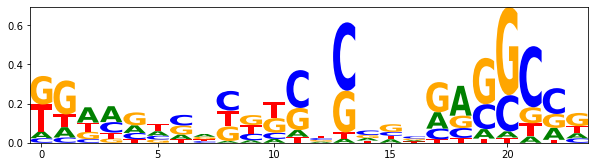

In [185]:
lm.Logo(seq_logo_mat)